In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the datasets
train_data = pd.read_csv('drug_review_train.csv')
test_data = pd.read_csv('drug_review_test.csv')
val_data = pd.read_csv('drug_review_validation.csv')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1002)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1002)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1002)>


In [2]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136


In [3]:
test_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48


In [4]:
val_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,191114,Campral,alcohol dependence,"""sober a year 8-25-11. god, aa and campral hav...",10.0,"September 3, 2011",33,41
1,1,142693,Levonorgestrel,birth control,"""i've been on birth control for a while now du...",4.0,"August 9, 2017",3,140


In [5]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(110811, 9)
(46108, 9)
(27703, 9)


In [6]:
# Preprocess the text data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [8]:
train_data['review'] = train_data['review'].apply(preprocess_text)
test_data['review'] = test_data['review'].apply(preprocess_text)
val_data['review'] = val_data['review'].apply(preprocess_text)

In [9]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,used restasis year seen almost progress life r...,2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,experience somewhat mixed using implanon nearl...,7.0,"August 7, 2016",4,136


In [16]:
train_data['review'][0]

'used restasis year seen almost progress life red bothersome eye trying various eye drop doctor recommended restasis said typically take 3 6 month really kick never kick put drop burn eye first 30 40 minute talked doctor said normal go away time every year around spring time eye get terrible irritated year maybe even worse year even though using restasis year difference notice first couple week ready move'

In [12]:
# Map ratings to three sentiment labels (negative, neutral, positive)
def map_sentiment(rating):
    if 1 <= rating <= 3:
        return 'Negative'
    elif 4 <= rating <= 7:
        return 'Neutral'
    else:
        return 'Positive'

In [17]:
train_data['sentiment'] = train_data['rating'].apply(map_sentiment)
test_data['sentiment'] = test_data['rating'].apply(map_sentiment)
val_data['sentiment'] = val_data['rating'].apply(map_sentiment)

In [18]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,used restasis year seen almost progress life r...,2.0,"April 20, 2013",69,147,Negative
1,1,143975,Etonogestrel,birth control,experience somewhat mixed using implanon nearl...,7.0,"August 7, 2016",4,136,Neutral


C:\Users\kamma\AppData\Local\Temp\ipykernel_29104\3147790667.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=train_data, palette='viridis')


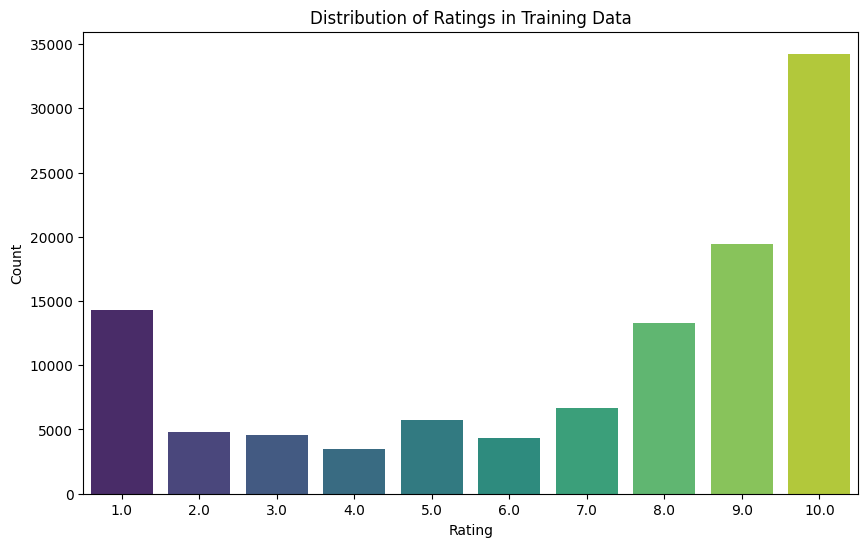

In [19]:
# EDA: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=train_data, palette='viridis')
plt.title('Distribution of Ratings in Training Data')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

C:\Users\kamma\AppData\Local\Temp\ipykernel_29104\3498459842.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=train_data, palette='viridis')


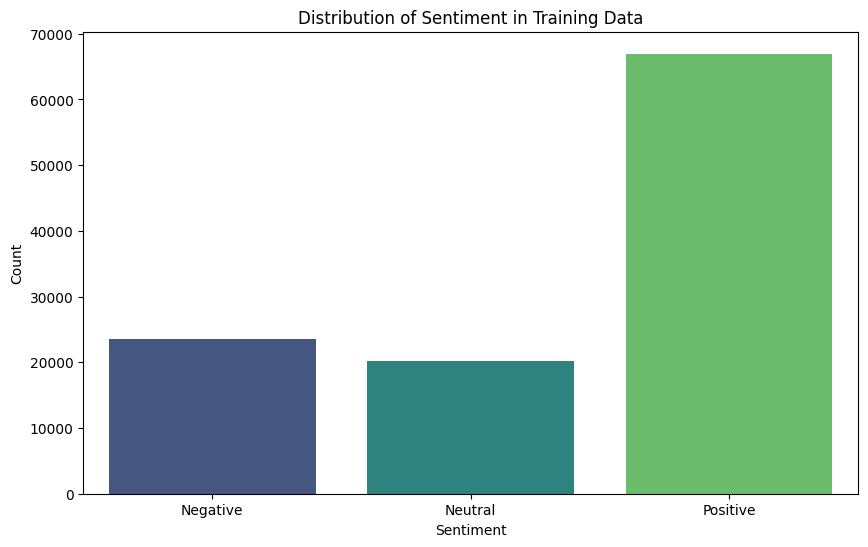

In [20]:
# EDA: Distribution of Sentiment
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_data, palette='viridis')
plt.title('Distribution of Sentiment in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [21]:
train_data['sentiment'].value_counts()

sentiment
Positive    66967
Negative    23602
Neutral     20242
Name: count, dtype: int64

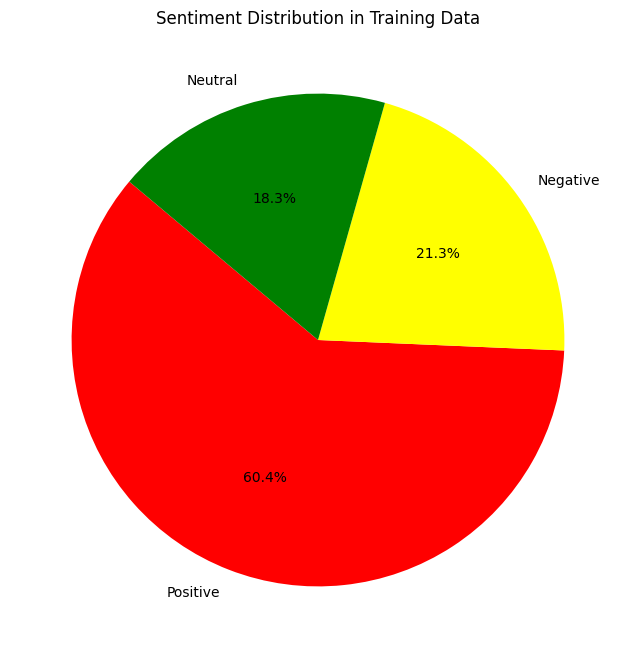

In [22]:
# EDA: Pie chart for sentiment distribution in training data
plt.figure(figsize=(8, 8))
train_sentiment_counts = train_data['sentiment'].value_counts()
plt.pie(train_sentiment_counts, labels=train_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Training Data')
plt.show()

In [23]:
train_sentiment_counts.index

Index(['Positive', 'Negative', 'Neutral'], dtype='object', name='sentiment')

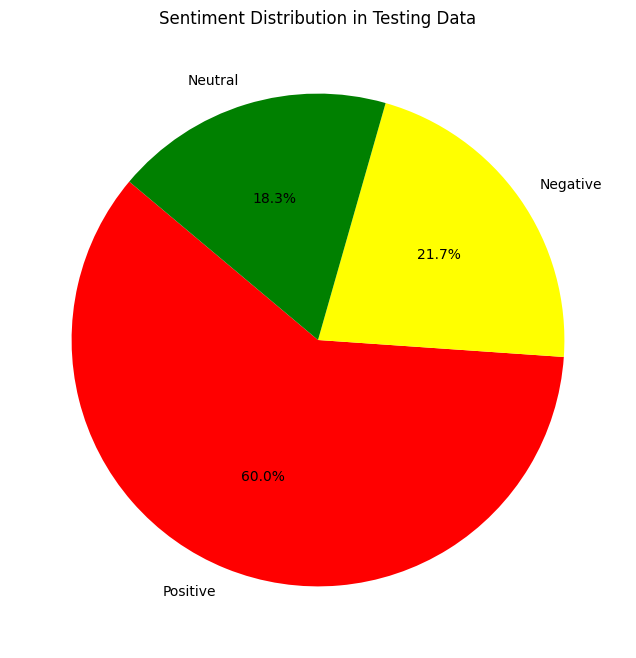

In [24]:
# EDA: Pie chart for sentiment distribution in testing data
plt.figure(figsize=(8, 8))
test_sentiment_counts = test_data['sentiment'].value_counts()
plt.pie(test_sentiment_counts, labels=test_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Testing Data')
plt.show()

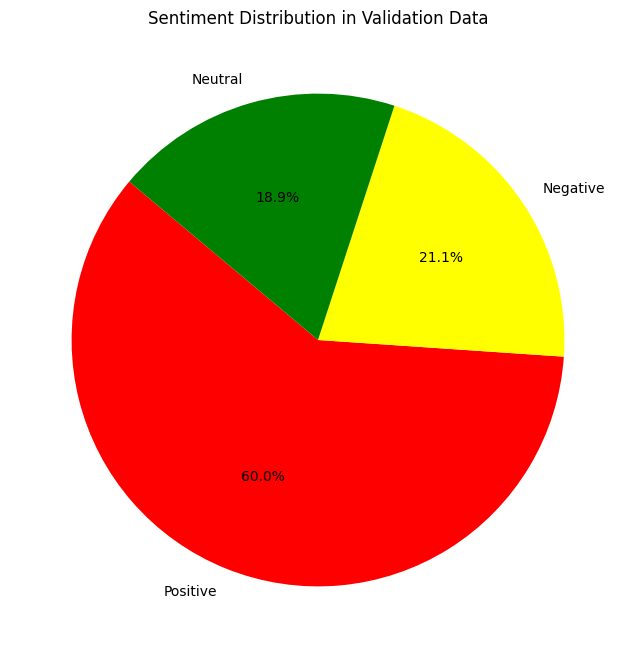

In [25]:
# EDA: Pie chart for sentiment distribution in validation data
plt.figure(figsize=(8, 8))
val_sentiment_counts = val_data['sentiment'].value_counts()
plt.pie(val_sentiment_counts, labels=val_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Validation Data')
plt.show()

In [26]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['review'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['review'])
X_val_tfidf = tfidf_vectorizer.transform(val_data['review'])

In [27]:
# Print original class distribution
print("Original class distribution:", Counter(train_data['sentiment']))

Original class distribution: Counter({'Positive': 66967, 'Negative': 23602, 'Neutral': 20242})


In [28]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, train_data['sentiment'])

In [29]:
# Print resampled class distribution
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({'Negative': 66967, 'Neutral': 66967, 'Positive': 66967})


In [30]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf_resampled, y_train_resampled)

MultinomialNB()

In [31]:
# Make predictions on the test dataset
y_test_pred = nb_model.predict(X_test_tfidf)
# Make predictions on the validation dataset
y_val_pred = nb_model.predict(X_val_tfidf)

In [32]:
# Evaluate the model on the test dataset
test_accuracy = accuracy_score(test_data['sentiment'], y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_data['sentiment'], y_test_pred))
test_cm = confusion_matrix(test_data['sentiment'], y_test_pred, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Test):\n{test_cm}')

Test Accuracy: 0.7730762557473757
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      9993
     Neutral       0.51      0.70      0.59      8444
    Positive       0.90      0.79      0.84     27671

    accuracy                           0.77     46108
   macro avg       0.72      0.76      0.74     46108
weighted avg       0.80      0.77      0.78     46108

Confusion Matrix (Test):
[[ 7792  1313   888]
 [ 1060  5916  1468]
 [ 1456  4278 21937]]


In [33]:
# Evaluate the model on the validation dataset
val_accuracy = accuracy_score(val_data['sentiment'], y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(val_data['sentiment'], y_val_pred))
val_cm = confusion_matrix(val_data['sentiment'], y_val_pred, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Validation):\n{val_cm}')

Validation Accuracy: 0.7746092480958741
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      5834
     Neutral       0.52      0.71      0.60      5238
    Positive       0.91      0.79      0.85     16631

    accuracy                           0.77     27703
   macro avg       0.73      0.76      0.74     27703
weighted avg       0.80      0.77      0.78     27703

Confusion Matrix (Validation):
[[ 4564   772   498]
 [  658  3695   885]
 [  822  2609 13200]]


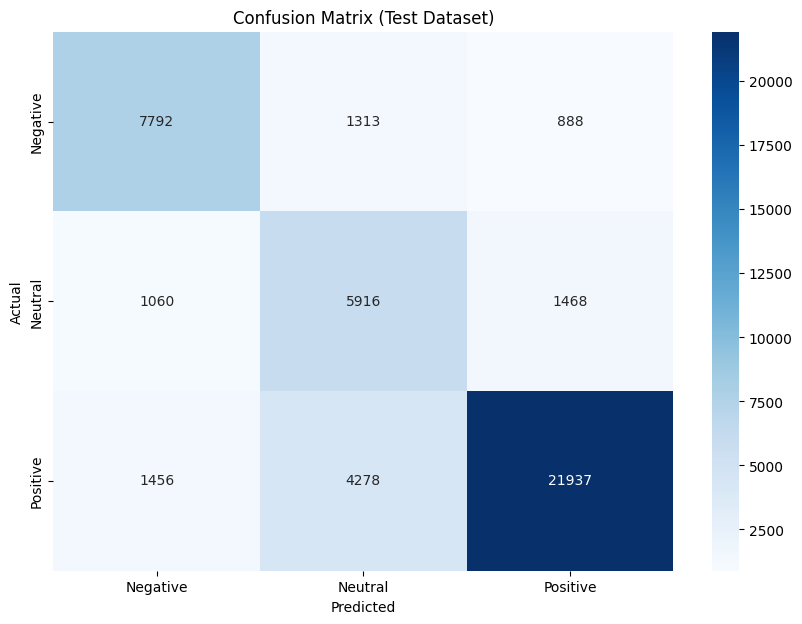

In [34]:
# Plot confusion matrix for the test dataset
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Dataset)')
plt.show()

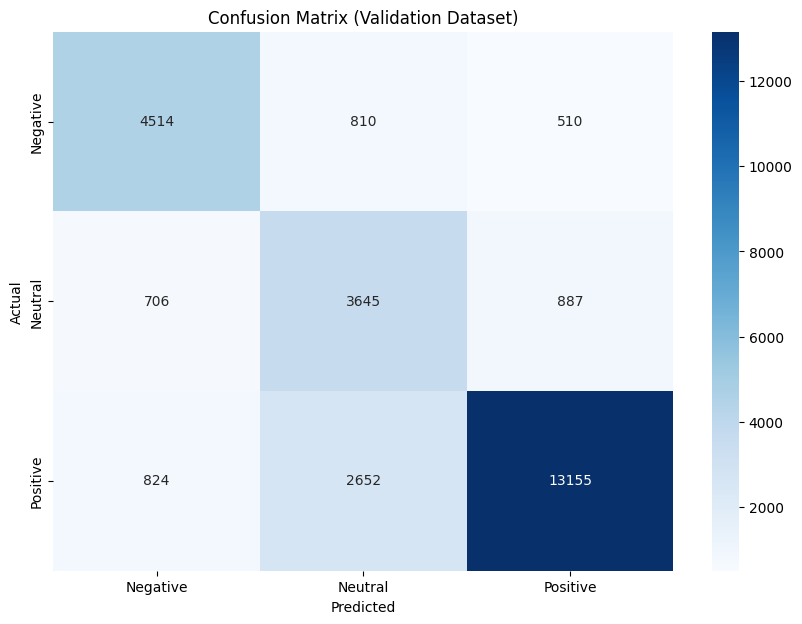

In [32]:
# Plot confusion matrix for the validation dataset
plt.figure(figsize=(10, 7))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Dataset)')
plt.show()